In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import norm
import scipy.optimize as opt

#import yfinance as yf  # Seems to be deprecated?

from Garch import GARCH

## Load Data
1. S&P500 data
2. Sentiment data (consisting of mean Positive, Negative and Neutral sentiment per day)
3. VIX (for comparison purpose)

In [2]:
start = datetime(2010, 1, 1)
end = datetime(2024, 9, 10)

# Load S&P data
prices_df = pd.read_csv('../data/spy_prices.csv')
prices_df.index = pd.to_datetime(prices_df['Date'], format='%Y-%m-%d %H:%M:%S%z', utc=True).dt.date

# Load Sentiment data
sentiment_df = pd.read_csv('../data/nyt_sentiment.csv')
sentiment_df.index = pd.DatetimeIndex(sentiment_df['adjusted_date'])

# Load Vix data
#vix = yf.Ticker('VIX').history(start=start, end=end)[['Close']].rename(columns={'Close':'VIX Close'})

In [3]:
# Merge all into one dataframe
#vix.index = pd.DatetimeIndex(vix.index.tz_localize(None))
data_with_sentiment = prices_df.join(sentiment_df, how='inner')#.join(vix[['VIX Close']], how='left')
data_with_sentiment = data_with_sentiment.drop(columns=['Date', 'adjusted_date'])
data_with_sentiment = data_with_sentiment.dropna()


log_returns = data_with_sentiment['log_returns']
exo_sentiment = data_with_sentiment[['mean_pos_sentiment',	'mean_neg_sentiment']].to_numpy()


data_with_sentiment.head()

,Open,High,Low,Close,Volume,returns,log_returns,mean_pos_sentiment,mean_neg_sentiment,mean_neutral_sentiment
2019-10-01,275.616000,276.282500,271.228221,271.450378,88242400,-0.011895,-0.011966,0.084752,0.525347,0.389900
2019-10-02,269.839692,269.848958,265.340835,266.655304,122539500,-0.017665,-0.017823,0.064854,0.476129,0.459017
2019-10-03,266.423921,268.867766,263.656106,268.839996,85278800,0.008193,0.008160,0.267430,0.271210,0.461360
2019-10-04,269.506467,272.737129,269.450899,272.477936,65091200,0.013532,0.013441,0.132889,0.533843,0.333267
2019-10-07,271.663341,273.320341,271.015344,271.302307,59610500,-0.004315,-0.004324,0.127010,0.374717,0.498273


### 1. Fit a basic GARCH(1,1) model without the exogenous term. 

In [4]:
garch_baseline = GARCH(p=1, q=1, z=0, verbose=True)
garch_baseline.train(log_returns)

Optimising...


d:\Programming\sentiment-analysis-volatility-forecasting\notebooks\Garch.py:171: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  avg_log_like += (np.log(sigma2[t]) + (y[t] - self.mu) ** 2 / sigma2[t]) / t_max


Optimising finished in 13.774s
{'omega': 3.601557579628784e-06, 'alpha': 0.15635795339172348, 'beta': 0.8223506675856701}
[[4.23804542e+12 1.76626817e+08 2.74626534e+08]
 [1.76626817e+08 1.46856941e+04 1.78319777e+04]
 [2.74626534e+08 1.78319777e+04 2.48917212e+04]]


In [5]:
garch_baseline.summary()

['omega', 'alpha', 'beta']
[3.601557579628784e-06, 0.15635795339172348, 0.8223506675856701]


,coef,std err,t,P>|t|
omega,0.000004,0.000001,3.595280,1.684573e-04
alpha,0.156358,0.025186,6.208072,3.663902e-10
beta,0.822351,0.025589,32.137090,3.503882e-165


### 2. Fit a basic GARCH(1,1) model without the exogenous term. 

In [6]:
x1 = exo_sentiment[:, [1]]

In [6]:
garch_with_sentiment = GARCH(p=1, q=1, z=2, verbose=True)
garch_with_sentiment.train(log_returns, x=exo_sentiment)

Optimising...
Optimising finished in 36.061s
{'omega': 8.702871007066218e-10, 'alpha': 0.4217986164894501, 'beta': 2.7874101153273674e-06, 'gammas': array([[1.81711096e-04, 2.16822740e-04],
       [4.38595151e-08, 1.80199519e-04]])}


IndexError: list index out of range

In [5]:
garch_with_sentiment.summary()

['omega', 'alpha', 'beta', 'gammas[0]', 'gammas[1]']
[3.156289130006824e-07, 0.1656293665018954, 0.8018305406165176, 2.5649092304852096e-23, 1.9935826262014295e-05]


ValueError: Length of values (4) does not match length of index (5)

In [8]:
garch_with_sentiment.summary()

,coef,std err,t,P>|t|
omega,3.201178e-07,0.000002,0.155691,4.381513e-01
alpha,1.656230e-01,0.026652,6.214199,3.528855e-10
beta,8.018429e-01,0.029598,27.090832,2.474019e-127
gammas[0],1.991212e-05,0.000012,1.667974,4.778824e-02


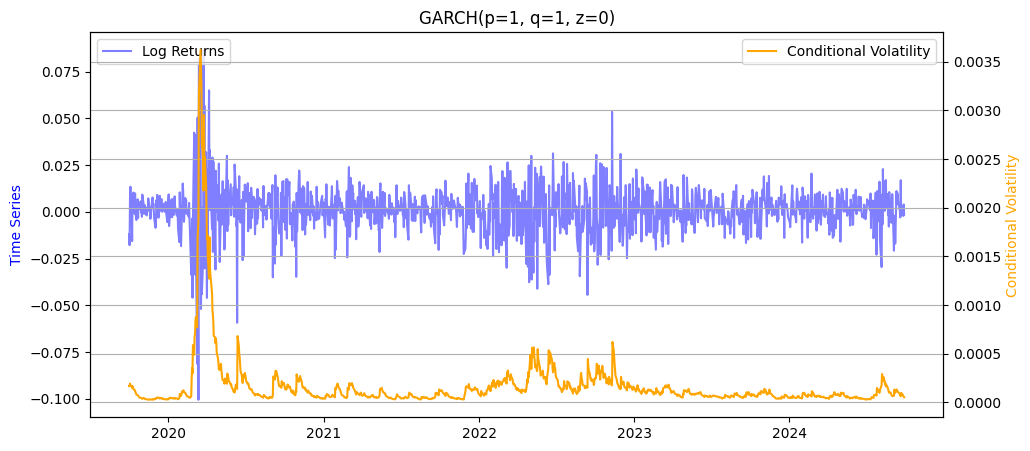

In [10]:
garch_baseline.plot()

In [31]:
garch_with_sentiment = GARCH(p=1, q=1, z=2)
garch_with_sentiment.train(log_returns, exo_sentiment)

C:\Users\Wei Hao\AppData\Local\Temp\ipykernel_42992\2467332480.py:180: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  avg_log_like += (np.log(sigma2[t]) + (y[t] - self.mu) ** 2 / sigma2[t]) / t_max


KeyboardInterrupt: 

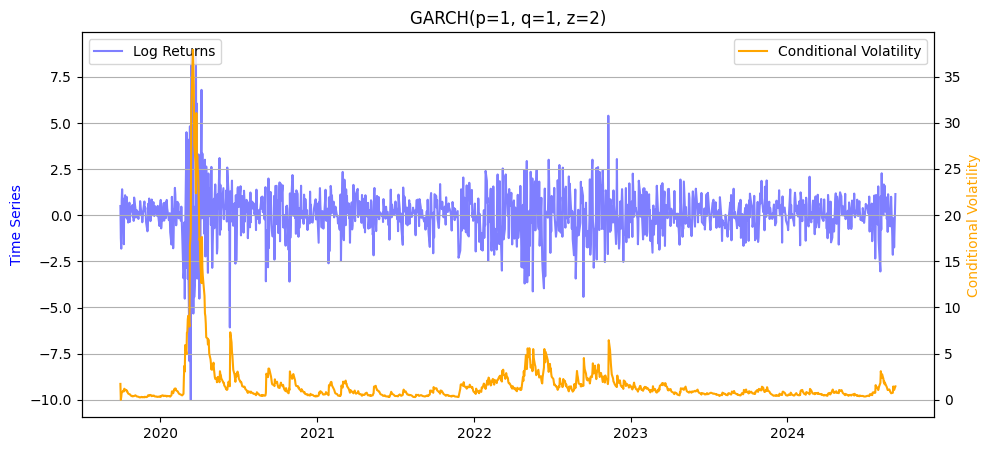

In [44]:
garch_with_sentiment.plot()

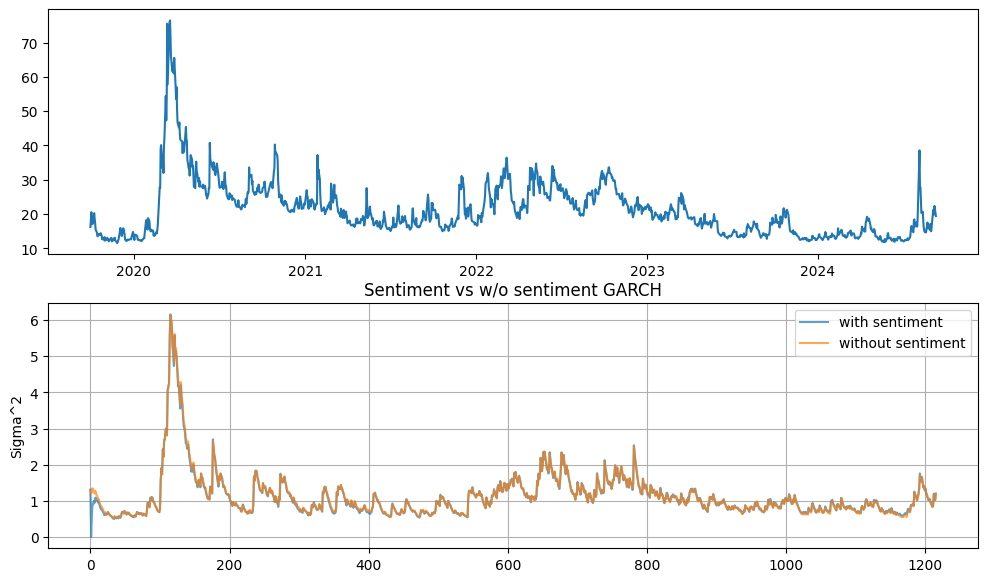

In [47]:
# Compare with and w/o sentiment

fig, ax = plt.subplots(2, 1, figsize=(12,7))

ax[0].plot(data_with_sentiment['VIX Close'])

ax[1].plot(np.sqrt(garch_with_sentiment.sigma2), label='with sentiment', alpha=0.7)
ax[1].plot(np.sqrt(garch_baseline.sigma2), label='without sentiment', alpha=0.7)

plt.ylabel("Sigma^2")

plt.title('Sentiment vs w/o sentiment GARCH')
plt.legend()
plt.grid()
plt.show()

In [15]:
def mse(actual, pred):
    return np.sum((actual-pred) ** 2)

mse_baseline = mse(data_with_sentiment['VIX Close'], garch_baseline.sigma2)
mse_sentiment = mse(data_with_sentiment['VIX Close'], garch_with_sentiment.sigma2)

print(f"MSE baseline: {mse_baseline:.3f}")
print(f"MSE with sentiment: {mse_sentiment:.3f}")

MSE baseline: 509949.092
MSE with sentiment: 511752.741


## Checking with arch library results for baseline GARCH model to make sure we are correct.

In [82]:
from arch import arch_model

model = arch_model(100*log_returns, vol='GARCH', mean='ARX', p=1, q=1, x=x1)
garch_fit = model.fit(disp='off')

In [83]:
garch_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          AR-X - GARCH Model Results                          
==============================================================================
Dep. Variable:            log_returns   R-squared:                       0.001
Mean Model:                      AR-X   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1765.45
Distribution:                  Normal   AIC:                           3540.90
Method:            Maximum Likelihood   BIC:                           3566.47
                                        No. Observations:                 1229
Date:                Fri, Feb 21 2025   Df Residuals:                     1227
Time:                        07:29:42   Df Model:                            2
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const          0.2201  7.645e-02      2.879  3.993e-03 [7.023e-02,  0.370]
x0            -0.2750      0.171     -1.606      0.108 [ -0.611,6.059e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0345  1.373e-02      2.512  1.199e-02 [7.587e-03,6.142e-02]
alpha[1]       0.1535  3.369e-02      4.557  5.192e-06   [8.749e-02,  0.220]
beta[1]        0.8265  3.461e-02     23.878 5.129e-126     [  0.759,  0.894]
============================================================================

Covariance estimator: robust
"""

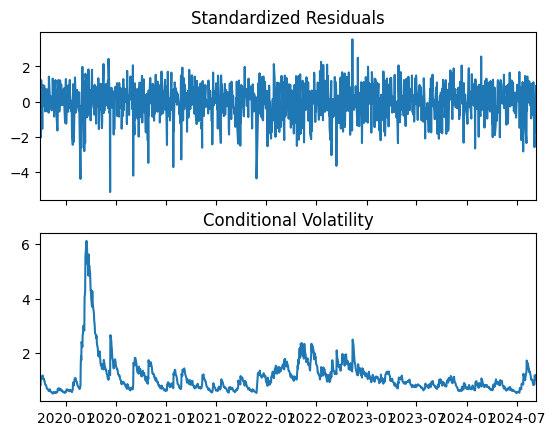

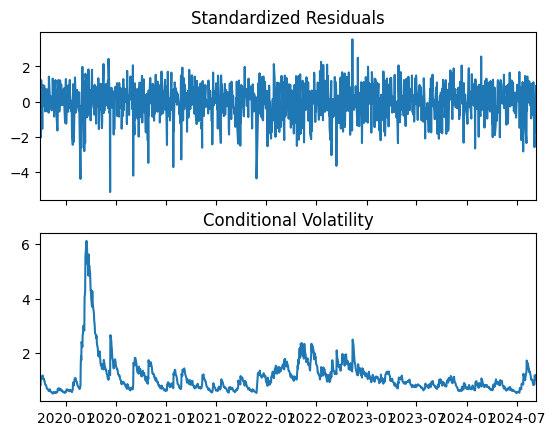

In [34]:
garch_fit.plot()

## Old Code
---

In [32]:
class GARCH_OLD:
    '''
    This class defines the GARCH model object which contains, functions
    for estimation and VaR forecasting.
    '''

    def __init__(self, alpha=0.1, beta=0.9, omega=0.1, gammas = 0.1, mu=None, p=1, q=1, z=1):
        """
        This class defines the GARCH model object which contains, functions
        for estimation and VaR forecasting.

        Parameters
        ----------
        alpha : float, optional
            _description_, by default 0.1
        beta : float, optional
            _description_, by default 0.9
        omega : float, optional
            _description_, by default 0.1
        gammas : float, optional
            _description_, by default 0.1
        mu : _type_, optional
            _description_, by default None
        p : int, optional
            _description_, by default 1
        q : int, optional
            _description_, by default 1
        z : int, optional
            lags in exogenous variable, by default 1 (i.e. X_t only)
        """
        # Initialize parameters
        self.gammas = gammas # Positive and negative sentiment only
        self.alpha = np.array([alpha]*p)
        self.beta = np.array([beta]*q)
        self.omega = omega
        self.p = p
        self.q = q
        self.z = z

        if (mu == None):
            self.mu = 0
        else:
            self.mu = mu

        self.sigma2 = np.array([])
        self.y = np.array([])

        
    def __repr__(self):
        return f"omega = {self.omega:.3g}\nalpha = {self.alpha:.3g}\nbeta  = {self.beta:.3g}"

    def train(self, y , x=None, callback_func=None):
        p, q, z = self.p, self.q, self.z

        self.mu = np.mean(y)
        self.y = np.array(y.values) if isinstance(y, pd.Series) else np.array(y)
        self.n_obs = len(y)
        
        e_t = y.values - self.mu

        init_omega = self.omega
        init_alpha = self.alpha
        init_beta = self.beta
        
        if x is not None:
            x = np.array(x)
            exo_var_count = x.shape[1] 
            init_gammas = np.array([self.gammas]*exo_var_count*z)
            init_params = self.inv_repam([init_omega, *init_alpha, *init_beta, *init_gammas])  # params has to be a 1d array
        else:
            init_params = self.inv_repam([init_omega, *init_alpha, *init_beta])

        opt_result = opt.minimize(self.log_likelihood,
                           x0=init_params,
                           args=(y, e_t, x, True),  
                           method='BFGS',
                           callback=callback_func,
                           options={'maxiter': 100})
        
        omega = self.repam(opt_result.x[0])
        alpha = self.repam(opt_result.x[1: self.p + 1])
        beta = self.repam(opt_result.x[self.p + 1: self.p + self.q + 1])
        if x is not None:
            gammas = self.repam(opt_result.x[self.p + self.q + 1 :]).reshape(z, x.shape[1])
            print(f"{omega=}\n {alpha=}\n {beta=}\n {gammas=}")
        else:
            print(f"{omega=}\n {alpha=}\n {beta=}\n")

        self.sigma2 = np.zeros(self.n_obs)
        self.sigma2[0] = np.var(y)
        
        for t in range(max(p, q, z), self.n_obs):
            if x is not None:
                self.sigma2[t] = (omega + np.sum(alpha * (e_t[t - p : t] ** 2)) 
                             + np.sum(beta * (self.sigma2[t - q : t])) 
                             + np.sum(gammas * x[t - z + 1 : t + 1, :])) 
            else:
                self.sigma2[t] = omega + np.sum(alpha * (e_t[t - p: t] ** 2)) + np.sum(beta * (self.sigma2[t - q: t]))

        #print('\nResults of BFGS minimization\n{}\n{}'.format(''.join(['-']*28), opt_result))
        #print('\nResulting params = {}'.format(self.params))


    def log_likelihood(self, params_repam, y: pd.Series, e_t, x=None, fmin=False):
        '''
        Takes the reparametrized 3X1 numpy array gamma = log((omega,alpha,beta))
        as input (if given or else uses the ones in self namespace).
        And returns either sum of all likelihood contributions that is a 1X1
        numpy array or both the likelihood and the (t_max,) numpy array of estimated conditional variances.
        '''
        p, q, z = self.p, self.q, self.z

        self.params = self.repam(params_repam)
        omega = self.params[0]
        alpha = self.params[1: self.p + 1]
        beta = self.params[self.p + 1: self.p + self.q + 1]

        if x is not None:
            gammas = self.params[self.p + self.q + 1 :].reshape(z, x.shape[1])

        t_max = len(y)
        avg_log_like = 0
        sigma2 = np.zeros(t_max + 1)
        sigma2[:max(p, q)] = np.var(y)

        self.mu = np.mean(y)
        e_t = y.values - self.mu

        for t in range(max(p, q), t_max):
            if x is not None:
                sigma2[t] = (omega + np.sum(alpha * (e_t[t - p : t] ** 2)) 
                             + np.sum(beta * (sigma2[t - q : t])) 
                             + np.sum(gammas * x[t - z + 1 : t + 1, :])) 
            else:
                sigma2[t] = omega + np.sum(alpha * (e_t[t - p: t] ** 2)) + np.sum(beta * (sigma2[t - q: t]))
                #print(f"{sigma2[t]=}")
            avg_log_like += (np.log (sigma2[t]) + (y[t] - self.mu)**2 / sigma2[t]) / t_max
        if fmin:
            #print(f"{avg_log_like=}")
            return avg_log_like
        else:
            return [avg_log_like, sigma2]
        

    def plot(self, figsize=(11, 5)):
        fig, ax1 = plt.subplots(figsize=figsize)

        returns_colour = 'blue'
        vol_colour = 'orange'

        ax1.plot(self.y, label='Log Returns', color=returns_colour, alpha=0.5)
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Log Returns', color=returns_colour)
        ax1.tick_params(axis='y', labelcolor=returns_colour)

        ax2 = ax1.twinx()
        ax2.plot(self.sigma2, label='Conditional Volatility', color=vol_colour)
        ax2.set_ylabel('Conditional Volatility', color=vol_colour)
        ax2.tick_params(axis='y', labelcolor=vol_colour)
        
        plt.title(f'GARCH(p={self.p}, q={self.q}, z={self.z})')
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        plt.grid()
        plt.show()


    def filter(self, y):
        omega = self.params[0]
        alpha = self.params[1]
        beta = self.params[2]

        t_max = len(y)
        sigma2 = np.zeros(t_max + 1)
        sigma2[0] = np.var(y)
        for t in range(1, t_max):
            sigma2[t] = omega + alpha * y[t - 1] ** 2 + beta * sigma2[t - 1]
        return sigma2

    def repam(self, params_repam):
        return np.exp(params_repam)

    def inv_repam(self, params):
        return np.log(params)

    def VaR(self, y, pct=(0.01, 0.025, 0.05)):
        est_variance = self.log_likelihood(y=y, fmin=False)[1]
        VaR = {}
        for alpha in pct:
            VaR[str(alpha)] = self.mu + norm.ppf(alpha) * np.sqrt(est_variance)
        return VaR

In [33]:
garch_baseline = GARCH_OLD(p=1, q=1, z=0)
garch_baseline.train(100*log_returns)

C:\Users\Wei Hao\AppData\Local\Temp\ipykernel_17788\2283911124.py:137: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  avg_log_like += (np.log (sigma2[t]) + (y[t] - self.mu)**2 / sigma2[t]) / t_max


omega=0.04226559236301376
 alpha=array([0.07969076])
 beta=array([0.85473757])



In [ ]:
garch_baseline

0.07910129965980646

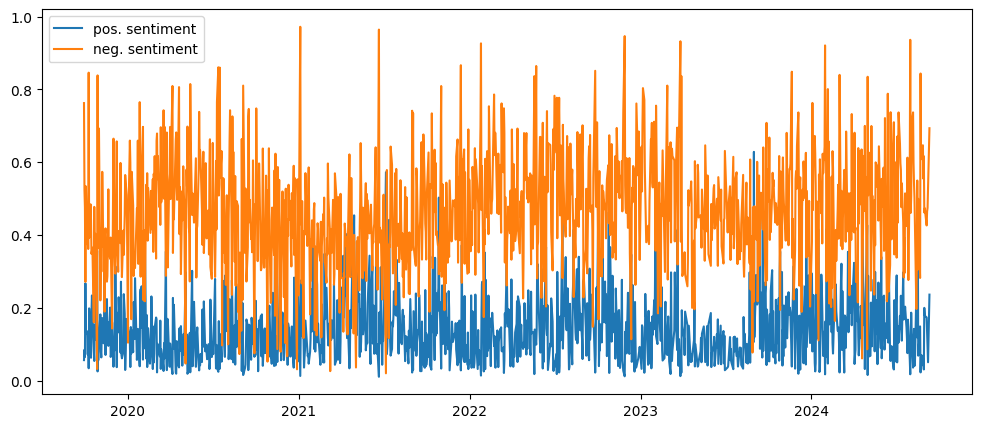

In [23]:
fig, axs = plt.subplots(figsize=(12,5))

plt.plot(data_with_sentiment['mean_pos_sentiment'], label='pos. sentiment')
plt.plot(data_with_sentiment['mean_neg_sentiment'], label='neg. sentiment')

plt.legend()
plt.show()

In [18]:
exo_sentiment

array([[0.05630815, 0.76260353],
       [0.08475246, 0.52534736],
       [0.06485389, 0.47612949],
       ...,
       [0.08226424, 0.4749225 ],
       [0.0504581 , 0.5328877 ],
       [0.2362758 , 0.69351994]])